In [120]:
%matplotlib inline

import json, glob, sys, os, gzip
from IPython.display import HTML
import ipywidgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahist import set_default_style, Hist1D, Hist2D
from tqdm.auto import tqdm

import uproot

In [121]:
# ! [ ! -d trig_eff_ntuples ] && scp -rp ucsd:~/2019/scouting/repo/analysis/trig_eff_ntuples/ .
! ls -lrth trig_eff_ntuples

total 74M
-rw-rw-r--+ 1 namin namin  43M Oct 22 16:43 data.root
-rw-rw-r--+ 1 namin namin 5.6M Oct 22 16:43 mc17.root
-rw-rw-r--+ 1 namin namin  26M Oct 22 16:43 mc18.root


In [122]:
set_default_style()

In [130]:
%%time
df_data = uproot.open("trig_eff_ntuples/data.root")["t"].pandas.df()
df_data17 = df_data[df_data.year == 2017].copy()
df_data18 = df_data[df_data.year == 2018].copy()
del df_data

df_mc17 = uproot.open("trig_eff_ntuples/mc17.root")["t"].pandas.df()
df_mc18 = uproot.open("trig_eff_ntuples/mc18.root")["t"].pandas.df()

CPU times: user 392 ms, sys: 40 ms, total: 432 ms
Wall time: 425 ms


In [131]:
import uproot_methods
make_vec = uproot_methods.TLorentzVectorArray.from_ptetaphim
for df in [
    df_mc17,
    df_mc18,
    df_data17,
    df_data18,
]:
    v1 = make_vec(df["mu1pt"],df["mu1eta"],df["mu1phi"],0.10566)
    v2 = make_vec(df["mu2pt"],df["mu2eta"],df["mu2phi"],0.10566)
    df["dimuon_eta"] = (v1+v2).eta
    df["minabsdxy"] = np.minimum(df["mu1dxy"].abs(), df["mu2dxy"].abs())

In [132]:
def hqe(df, varexp, sel):
    return df[df.eval(sel)].eval(varexp)

In [133]:
%%time
def get_pt_weights(df_data, df_mc):
    ptbins = np.concatenate([np.arange(3,10), np.arange(10,18,2), np.array([18,300])])
    v = hqe(df_data, "mu2pt", "vtx_good and pass_materialveto and mu1pt>3 and mu2pt>3 and 3.0<mass<3.2")
    hdata = Hist1D(v, bins=ptbins)
    v = hqe(df_mc, "mu2pt", "vtx_good and pass_materialveto and mu1pt>3 and mu2pt>3 and 3.0<mass<3.2")
    hmc = Hist1D(v, bins=ptbins)
    hr = hdata.normalize()/hmc.normalize()
    return hr.lookup(df_mc["mu2pt"])

df_data17["weight"] = 1.
df_data18["weight"] = 1.
df_mc17["weight"] = get_pt_weights(df_data17, df_mc17)
df_mc18["weight"] = get_pt_weights(df_data18, df_mc18)

CPU times: user 264 ms, sys: 59 ms, total: 323 ms
Wall time: 283 ms


In [134]:
def get_h_eff(df, varexp, bins, maxlxy=None, minlxy=0.):
    if maxlxy is None: maxlxy = 999.
    overflow = True
    if "lxy" in varexp: overflow=False
    selstr = f"vtx_good and pass_materialveto and mu1pt>3 and mu2pt>3 and 3.0<mass<3.2 and recolxy<{maxlxy} and recolxy>{minlxy}"
    df = df[df.eval(selstr)]
    hden = Hist1D(df.eval(varexp),bins=bins, weights=df["weight"], overflow=overflow)
    df = df[df.eval(f"hlt and l1")]
    hnum = Hist1D(df.eval(varexp),bins=bins, weights=df["weight"], overflow=overflow)
    return hnum.divide(hden,binomial=True)


In [135]:
def sideband_info(h):
    hmask = h.copy()
    selmask = (hmask.bin_centers < 3.2) & (hmask.bin_centers > 3.0)
    hmask._counts[selmask] *= np.nan
    xmask = h.bin_centers[selmask]
    polyfunc = lambda x,a,b: a*x+b
    res = hmask.fit(polyfunc, draw=False)["params"]
    sideband_integral = polyfunc(xmask, res["a"]["value"], res["b"]["value"]).sum()
    peak_integral = h.counts[selmask].sum()
    return float(peak_integral), float(sideband_integral)

def get_h_eff(df, varexp, bins, maxlxy=None, minlxy=0., isdata=False):
    if maxlxy is None: maxlxy = 999.
    overflow = True
    if "lxy" in varexp: overflow=False
    selstr = f"vtx_good and pass_materialveto and mu1pt>3 and mu2pt>3 and recolxy<{maxlxy} and recolxy>{minlxy}"
    selstr_peak = selstr + " and 3.0<mass<3.2 "
    selstr_side = selstr + " and ((2.6<mass<3.0) or (3.2<mass<3.4))"
    selstr_both = selstr + " and 2.6<mass<3.4 "
    df_both = df[df.eval(selstr)]
    df_peak = df[df.eval(selstr_peak)]
    df_side = df[df.eval(selstr_side)]

    count_peak, count_side = sideband_info(Hist1D(df_both["mass"], bins="50,2.6,3.4", overflow=False))

    df = df_peak
    hden_peak = Hist1D(df.eval(varexp),bins=bins, weights=df["weight"], overflow=overflow)
    hnum_peak = Hist1D(df[df.eval("hlt and l1")].eval(varexp),bins=bins, weights=df[df.eval("hlt and l1")]["weight"], overflow=overflow)

    if isdata:
        df = df_side
        hden_side = Hist1D(df.eval(varexp),bins=bins, weights=df["weight"], overflow=overflow)
        hnum_side = Hist1D(df[df.eval("hlt and l1")].eval(varexp),bins=bins, weights=df[df.eval("hlt and l1")]["weight"], overflow=overflow)

        hnum_peak = hnum_peak - hnum_side * count_side/count_peak
        hden_peak = hden_peak - hden_side * count_side/count_peak
    return hnum_peak.divide(hden_peak,binomial=False)

In [136]:
# fig, ax = plt.subplots()
# Hist1D(df_data18[df_data18.eval("vtx_good")]["recolxy"], bins="100,0,11").plot(histtype="step")
# Hist1D(df_data18[df_data18.eval("vtx_good and pass_materialveto")]["recolxy"], bins="100,0,11").plot(histtype="step")
# ax.set_yscale("log")

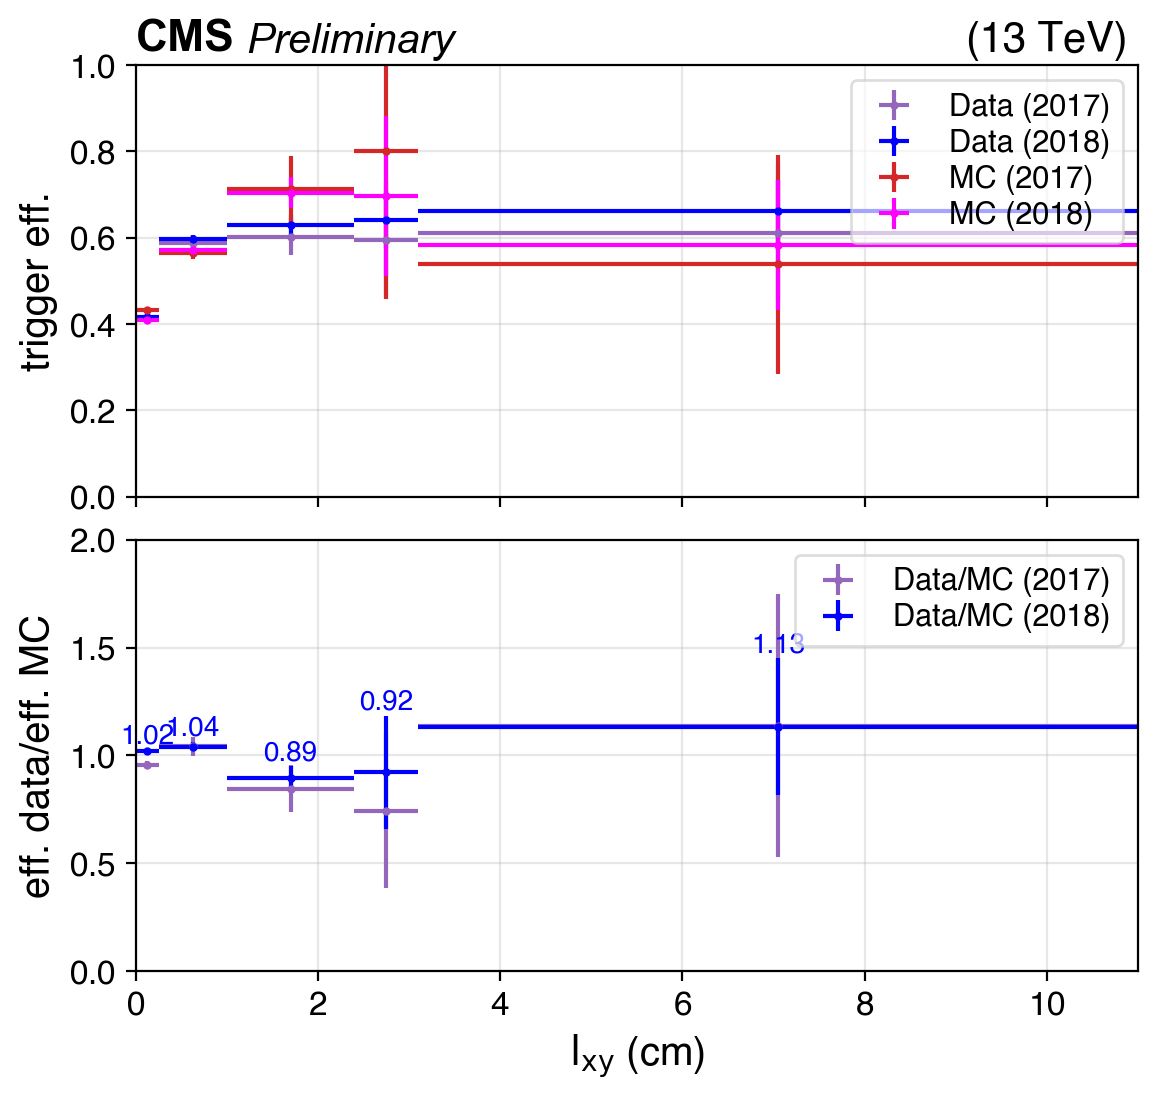

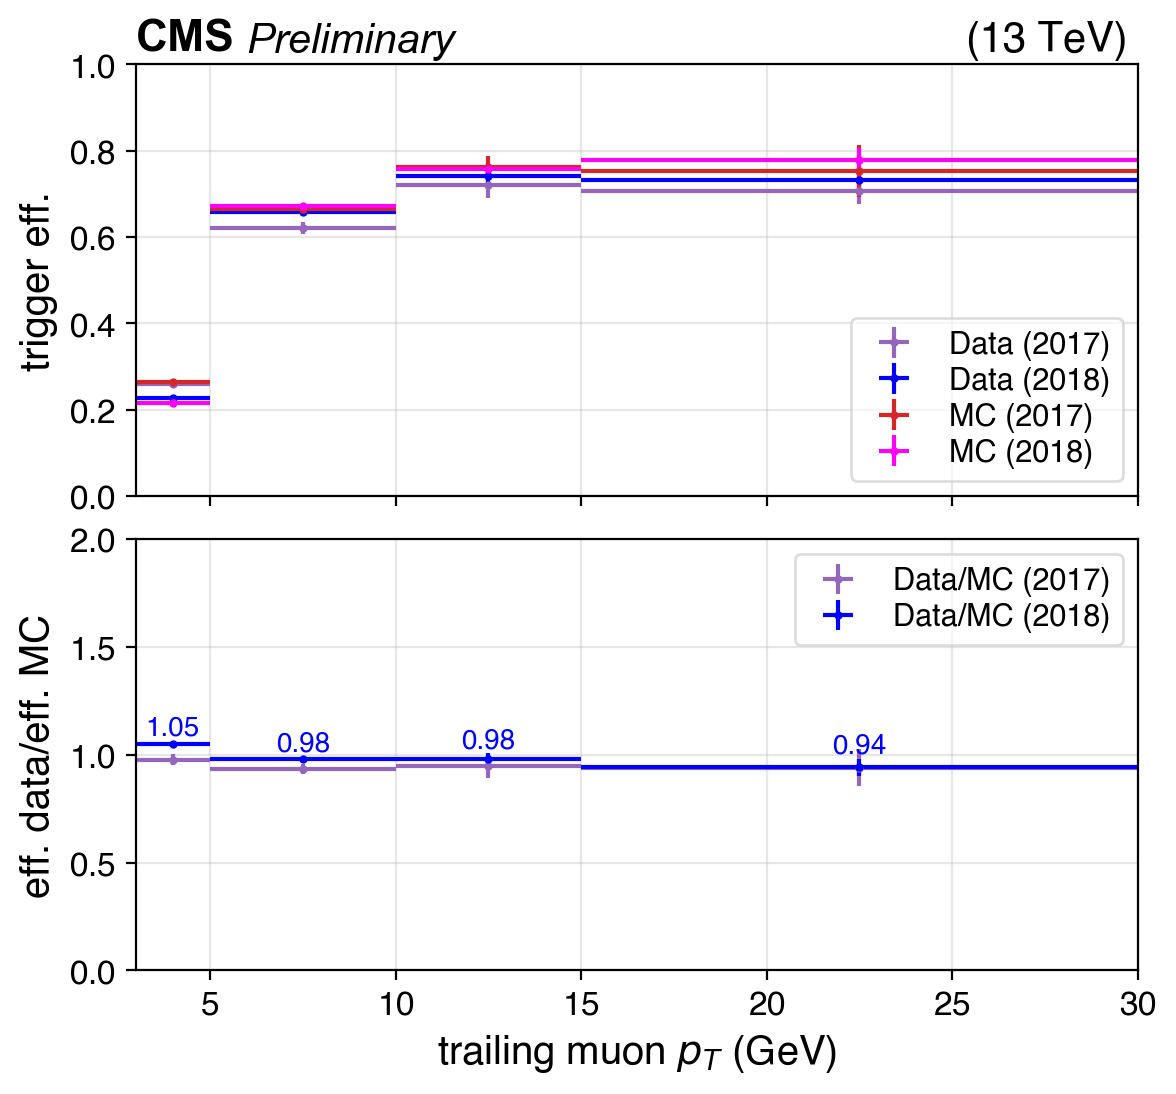

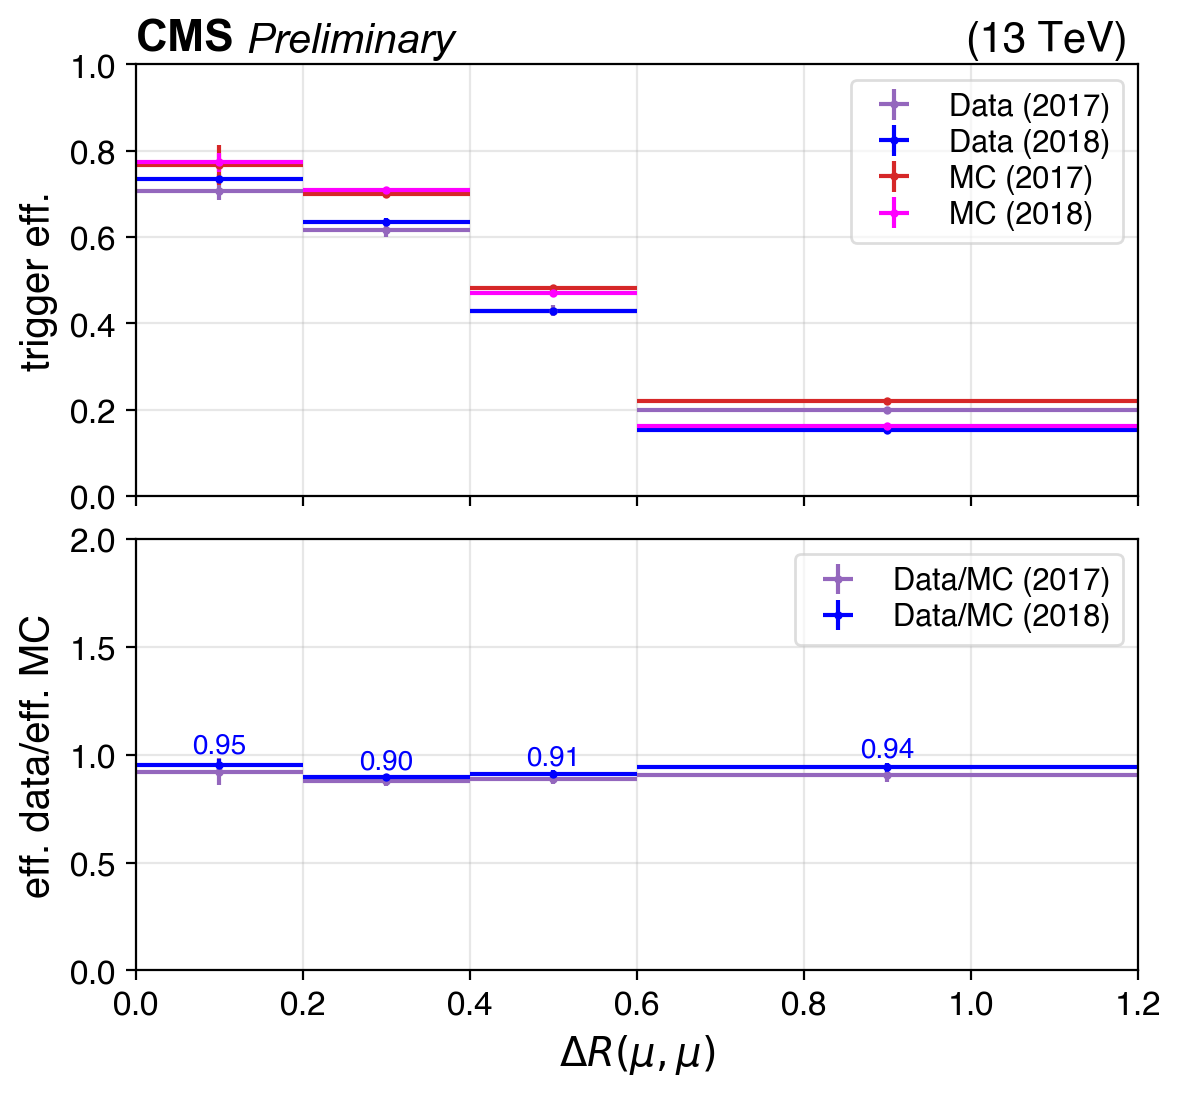

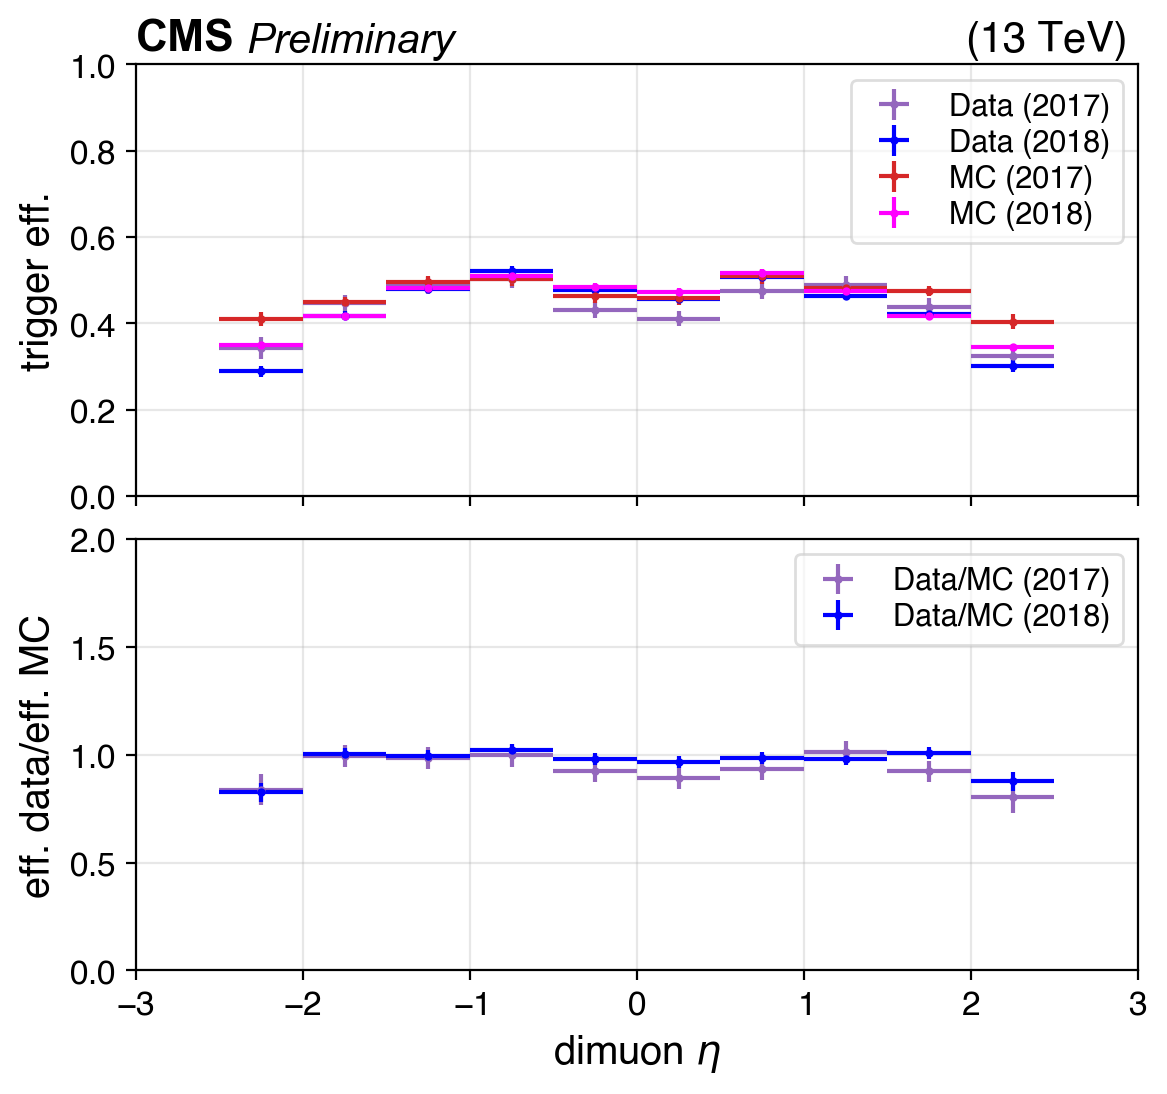

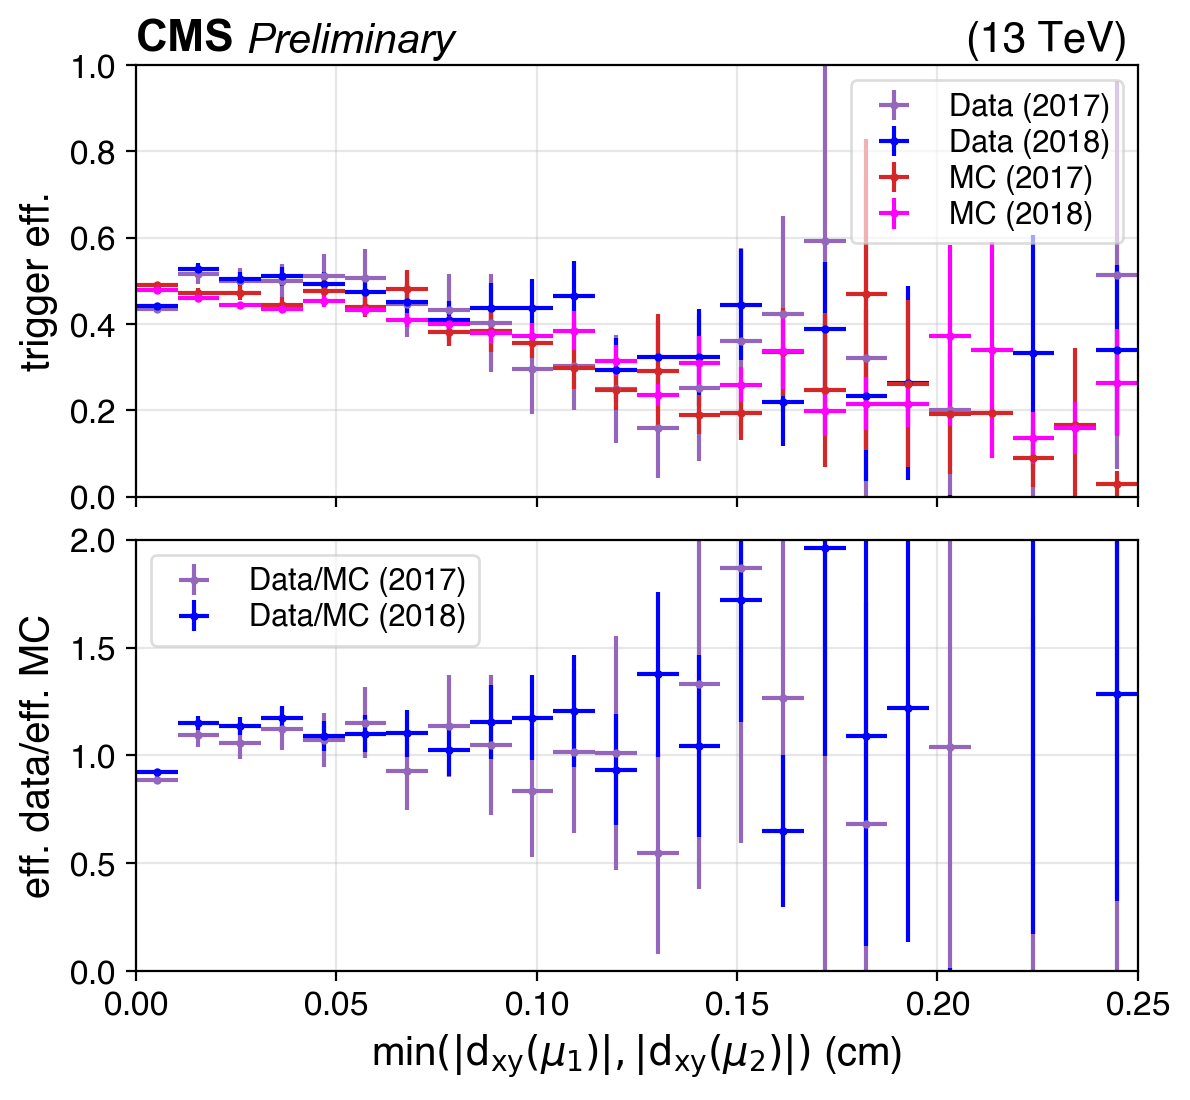

In [137]:
!mkdir -p trigger_sf_plots/

maxlxy = None
# maxlxy = 0.25

for varexp, bins in [
    ["recolxy", [0,0.25,1.,2.4,3.1,11]],
    ["mu2pt", [3.,5.,10.,15,30]],
    ["dr", [0.,0.2,0.4,0.6,1.2]],
    ["dimuon_eta", np.linspace(-3,3,13)],
    ["minabsdxy", np.linspace(0., 0.25, 25)],
]:
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(6,6))


    # varexp, bins = "recolxy", [0,0.25,1.,2.4,3.1,5,11]
    # varexp, bins = "mu2pt", [3.,5.,10.,15,30]
    # varexp, bins = "dr", [0.,0.2,0.4,0.6,1.2]

    dfmcs = dict()
    dfmcs[2017] = df_mc17
    dfmcs[2018] = df_mc18

    heffmcs = {
        2017: get_h_eff(df_mc17, varexp, bins, maxlxy=maxlxy, isdata=False),
        2018: get_h_eff(df_mc18, varexp, bins, maxlxy=maxlxy, isdata=False),
    }
    heffdatas = {
        2017: get_h_eff(df_data17, varexp, bins, maxlxy=maxlxy, isdata=True),
        2018: get_h_eff(df_data18, varexp, bins, maxlxy=maxlxy, isdata=True),
    }

    ax=ax1
    for year in [2017, 2018]:
        color = {2017:"C4",2018:"b"}[year]
        heffdatas[year].plot(ax=ax,show_errors=True,color=color, label=f"Data ({year})", markersize=2)
    for year in [2017, 2018]:
        color = {2017:"C3",2018:"magenta"}[year]
        heffmcs[year].plot(ax=ax,show_errors=True,color=color, label=f"MC ({year})", markersize=2)
    ax.legend()
    ax.set_ylabel("trigger eff.")
    ax.grid(alpha=0.3)
    ax.set_ylim([0.0,1.0])

    ax=ax2
    show_counts = False
    if varexp in ["recolxy", "mu2pt", "dr"]:
        show_counts = True
    for year in [2017, 2018]:
        color = {2017:"C4",2018:"b"}[year]
        (heffdatas[year]/heffmcs[year]).plot(
            ax=ax,show_errors=True,color=color, markersize=2, show_counts=(show_counts and year == 2018), counts_fmt_func="{:.2f}".format,
            label=f"Data/MC ({year})",
        )
    ax.grid(alpha=0.3)
    if varexp in ["recolxy", "mu2pt", "dr"]:
#         ax.set_ylim([0.5,1.5])
        ax.set_ylim([0.,2.])
    else:
        ax.set_ylim([0.,2.])
    ax.set_ylabel("eff. data/eff. MC")
    xlabel = {
        "recolxy": "$\mathrm{l_{xy}}$ (cm)",
        "mu2pt": "trailing muon $p_T$ (GeV)",
        "dr": "$\Delta R(\mu,\mu)$",
        "dimuon_eta": r"dimuon $\eta$",
        "minabsdxy": r"min$(|\mathrm{d_{xy}}(\mu_1)|, |\mathrm{d_{xy}}(\mu_2)|)$ (cm)",
    }.get(varexp,"")
    ax.set_xlabel(xlabel)

    def add_cms_info(ax, typ="Preliminary", lumi="", xtype=0.11):
        ax.text(0.0, 1.01,"CMS", horizontalalignment='left', verticalalignment='bottom', transform = ax.transAxes, name="Arial", weight="bold", size=16)
        ax.text(xtype, 1.01,"Preliminary", horizontalalignment='left', verticalalignment='bottom', transform = ax.transAxes, name="Arial", style="italic", size=15)
    #     ax.text(0.99, 1.01,"%s fb${}^\mathregular{-1}$ (13 TeV)" % (lumi), horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size="x-large")
        ax.text(0.99, 1.01,"(13 TeV)", horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size=15)

    add_cms_info(ax1)

    fig.savefig(f"trigger_sf_plots/datamc_{varexp}.pdf")
#     fig.savefig(f"trigger_sf_plots/datamc_{varexp}.png")

In [144]:
fig, ax = plt.subplots()

bins = [1.,2.4,3.1,5,11]
for minlxy, maxlxy in zip(bins[:-1],bins[1:]):
    selstr = f"vtx_good and pass_materialveto and mu1pt>3 and mu2pt>3 and recolxy<{maxlxy} and recolxy>{minlxy}"
    h = sum(Hist1D(df[df.eval(selstr)]["mass"],bins="50,2.6,3.4", weights=df[df.eval(selstr)]["weight"], overflow=False) for df in [df_data17, df_data18])
    h = Hist1D(h, label=f"{minlxy:.1f}<$\mathrm{{l_{{xy}}}}$<{maxlxy:.1f} cm").normalize()
    h.plot(histtype="step")
ax.set_ylabel("arb. units")
ax.set_xlabel("dimuon mass (GeV)")

add_cms_info(ax)

fig.savefig(f"trigger_sf_plots/jpsimass.pdf")

def get_trigger_sf_or_error(lxy, mu2pt, error=False):
    if (mu2pt > 30.0): mu2pt = 29.9
    if (lxy < 0.25):
        if ((mu2pt >= 3.0) and (mu2pt < 5.0)): return (0.034 if error else 1.031)
        if ((mu2pt >= 5.0) and (mu2pt < 10.0)): return (0.040 if error else 0.963)
        if ((mu2pt >= 10.0) and (mu2pt < 15.0)): return (0.041 if error else 0.975)
        if ((mu2pt >= 15.0) and (mu2pt < 30.0)): return (0.080 if error else 0.945)
    if ((lxy < 1.0) and (lxy > 0.25)):
        if ((mu2pt >= 3.0) and (mu2pt < 5.0)): return (0.199 if error else 1.192)
        if ((mu2pt >= 5.0) and (mu2pt < 10.0)): return (0.027 if error else 0.990)
        if ((mu2pt >= 10.0) and (mu2pt < 15.0)): return (0.043 if error else 0.988)
        if ((mu2pt >= 15.0) and (mu2pt < 30.0)): return (0.085 if error else 0.937)
    if (lxy >= 1.0):
        if ((lxy >= 1.0) and (lxy < 2.4)): return (0.127 if error else 1.000)
        if ((lxy >= 2.4) and (lxy < 3.1)): return (0.248 if error else 1.000)
       

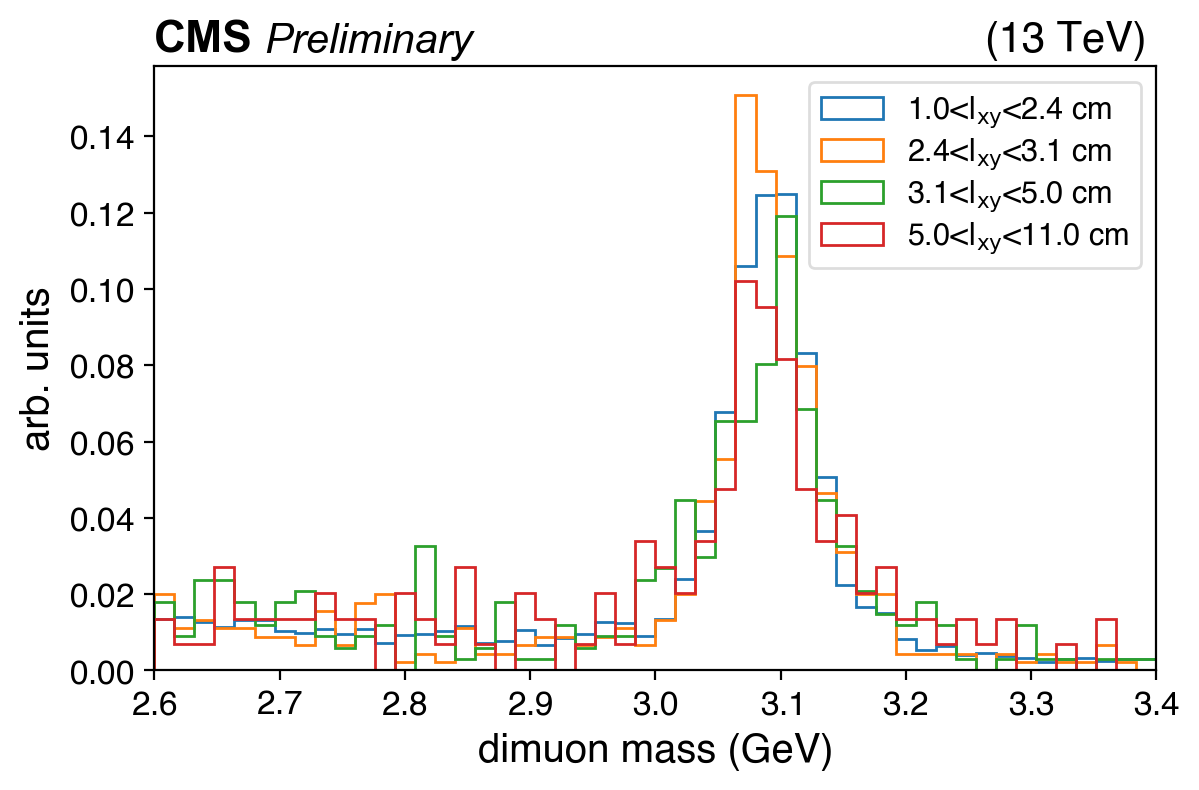

In [139]:

def get_one_year(year, python=False):
    buff = ""
    if year == 2017:
        dfd = df_data17
        dfm = df_mc17
    if year == 2018:
        dfd = df_data18
        dfm = df_mc18
    elif year == "both":
        dfd = pd.concat([df_data17, df_data18])
        dfm = pd.concat([df_mc17, df_mc18])

    minlxy = 0.
    maxlxy = 0.25
    varexp, bins = "mu2pt", [3.,5.,10.,15,30]
    h = get_h_eff(dfd, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=True)/get_h_eff(dfm, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=False)
    lows = h.edges[:-1]
    highs = h.edges[1:]
    values = h.counts
    errors = np.hypot(1-values, h.errors)
    if python:
        buff += (f"    if (lxy < {maxlxy}):\n")
    else:
        buff += (f"    if (lxy < {maxlxy}) {{\n")
    for low,high,value,error in zip(lows,highs,values,errors):
        if python:
            buff += (f"        if ((mu2pt >= {low}) and (mu2pt < {high})): return ({error:.3f} if error else {value:.3f})\n")
        else:
            buff += (f"        if ((mu2pt >= {low}) and (mu2pt < {high})) return (error ? {error:.3f} : {value:.3f});\n")
        
    minlxy = 0.25
    maxlxy = 1.0
    varexp, bins = "mu2pt", [3.,5.,10.,15,30]
    h = get_h_eff(dfd, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=True)/get_h_eff(dfm, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=False)
    lows = h.edges[:-1]
    highs = h.edges[1:]
    values = h.counts
    errors = np.hypot(1-values, h.errors)
    if python:
        buff += (f"    if ((lxy < {maxlxy}) and (lxy > {minlxy})):\n")
    else:
        buff += (f"    if ((lxy < {maxlxy}) and (lxy > {minlxy})) {{\n")
    for low,high,value,error in zip(lows,highs,values,errors):
        if python:
            buff += (f"        if ((mu2pt >= {low}) and (mu2pt < {high})): return ({error:.3f} if error else {value:.3f})\n")
        else:
            buff += (f"        if ((mu2pt >= {low}) and (mu2pt < {high})) return (error ? {error:.3f} : {value:.3f});\n")
            
    if python:
        buff += (f"    if (lxy >= {maxlxy}):\n")
    else:
        buff += (f"    if (lxy >= {maxlxy}) {{\n")
        
    minlxy = 1.0
    maxlxy = None
    varexp, bins = "recolxy", [1.,2.4,3.1,11]
    h = get_h_eff(dfd, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=True)/get_h_eff(dfm, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=False)
    lows = h.edges[:-1]
    highs = h.edges[1:]
    values = h.counts
    errors = np.hypot(1-values, h.errors)
    for low,high,value,error in zip(lows,highs,values,errors):
        value = 1.
        if python:
            buff += (f"        if ((lxy >= {low}) and (lxy < {high})): return ({error:.3f} if error else {value:.3f})\n")
        else:
            buff += (f"        if ((lxy >= {low}) and (lxy < {high})) return (error ? {error:.3f} : {value:.3f});\n")
    if python:
        pass
    else:
        buff += ("    }\n")
    return buff

def get_macro(python=False):
    buff = ""
    if python:
        buff += ("def get_trigger_sf_or_error(lxy, mu2pt, error=False):\n")
        buff += ("    if (mu2pt > 30.0): mu2pt = 29.9\n")
    else:
        buff += ("float get_trigger_sf_or_error(float lxy, float mu2pt, bool error=false) {\n")
        buff += ("    if (mu2pt > 30.0) mu2pt = 29.9;\n")
    buff += get_one_year("both", python=python)
    if python:
        buff += ("    return (0. if error else 1.)\n")
    else:
        buff += ("    return (error ? 0.0 : 1.0);\n")
        buff += ("}\n")
    return buff
    
print(get_macro(python=True))
print(get_macro(python=False))

In [140]:
exec(get_macro(python=True))

In [141]:
import numba
get_trigger_sf_or_error = numba.njit(get_trigger_sf_or_error)
get_trigger_sf_or_error(0.75, 20., False)

0.937

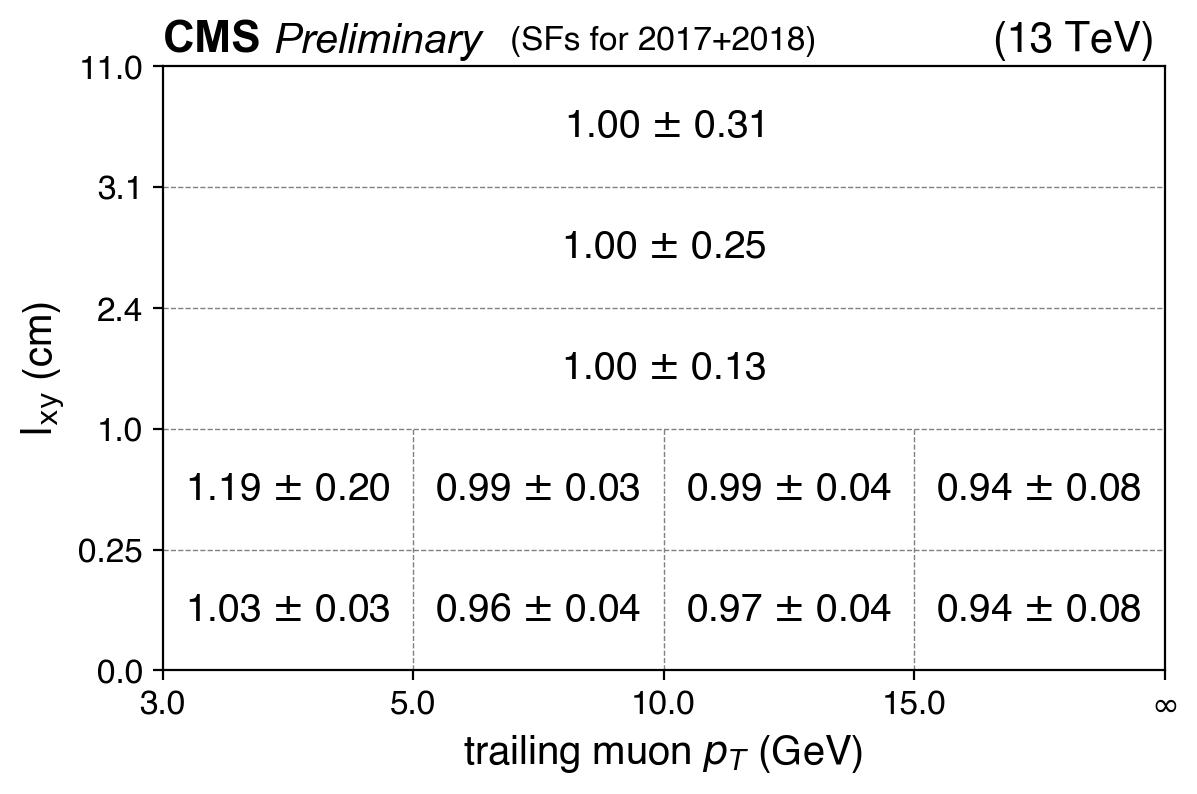

In [142]:
year = "both"
if year == 2017:
    dfd = df_data17
    dfm = df_mc17
elif year == 2018:
    dfd = df_data18
    dfm = df_mc18
elif year == "both":
    dfd = pd.concat([df_data17, df_data18])
    dfm = pd.concat([df_mc17, df_mc18])

fig, ax = plt.subplots()



ax.xaxis.set_ticks(np.arange(5))
ax.yaxis.set_ticks(np.arange(6))
ax.xaxis.set_ticklabels([3.0, 5.0, 10., 15., r"$\infty$"])
ax.yaxis.set_ticklabels([0., 0.25, 1.0, 2.4, 3.1, 11.0])

ax.set_xlabel("trailing muon $p_T$ (GeV)")
ax.set_ylabel("$\mathrm{l_{xy}}$ (cm)")

linekw = dict(color="gray", linestyle="--", linewidth=0.5)
for i in [1., 2., 3., 4.]:
    ax.plot([0., 4.], [i, i], **linekw)
for i in [1., 2., 3.]:
    ax.plot([i, i], [0., 2.], **linekw)

minlxy, maxlxy = 0.0, 0.25
varexp, bins = "mu2pt", [3.,5.,10.,15,30]
h = get_h_eff(dfd, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=True)/get_h_eff(dfm, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=False)
lows = h.edges[:-1]
highs = h.edges[1:]
values = h.counts
errors = np.hypot(1-values, h.errors)
for i,(low,high,value,error) in enumerate(zip(lows,highs,values,errors)):
    ax.text(0.5+i, 0.5, f"{value:.2f} $\\pm$ {error:.2f}", ha="center", va="center", fontsize=14)

minlxy, maxlxy = 0.25, 1.0
varexp, bins = "mu2pt", [3.,5.,10.,15,30]
h = get_h_eff(dfd, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=True)/get_h_eff(dfm, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=False)
lows = h.edges[:-1]
highs = h.edges[1:]
values = h.counts
errors = np.hypot(1-values, h.errors)
for i,(low,high,value,error) in enumerate(zip(lows,highs,values,errors)):
    ax.text(0.5+i, 1.5, f"{value:.2f} $\\pm$ {error:.2f}", ha="center", va="center", fontsize=14)

minlxy = 1.
maxlxy = 999.
varexp, bins = "recolxy", [1.,2.4,3.1,11]
h = get_h_eff(dfd, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=True)/get_h_eff(dfm, varexp, bins, maxlxy=maxlxy, minlxy=minlxy, isdata=False)
lows = h.edges[:-1]
highs = h.edges[1:]
values = h.counts
errors = np.hypot(1-values, h.errors)
values = 0*values + 1.
for i,(low,high,value,error) in enumerate(zip(lows,highs,values,errors)):
    ax.text(2.0, 2.5+i, f"{value:.2f} $\\pm$ {error:.2f}", ha="center", va="center", fontsize=14)
    
ax.set_xlim([0, 4.])
ax.set_ylim([0, 5.])

add_cms_info(ax)
ax.set_title(f"(SFs for 2017+2018)")
fig.savefig(f"trigger_sf_plots/sf_2d.pdf")

In [15]:
# df = dfm.query(f"vtx_good and mu1pt>3 and mu2pt>3 and 3.0<mass<3.2 and l1 and hlt")[["mu2pt","recolxy"]]
# def conv_pt(x):
#     return np.clip((x-3.)/(30-3.)*4, None, 4.)
# def conv_lxy(x):
#     return np.clip((x-0.)/(11-0.)*6, None, 6.)
# ax.scatter(
#     conv_pt(df["mu2pt"]),
#     conv_lxy(df["recolxy"]),
#     alpha=0.15,
#     s = 2.,
#     color="r",
# )


In [143]:
# selstr = f"vtx_good and pass_materialveto and mu1pt>3 and mu2pt>3 and recolxy<11 and recolxy>0"
# # selstr = f"vtx_good and pass_materialveto and mu1pt>3 and mu2pt>3 and recolxy<11 and recolxy>0 and l1 and hlt"
# def f(df):
# #     return Hist1D(df.query(selstr)["mass"], bins="50,2.5,3.5", overflow=False)
#     return Hist1D(df.query(selstr + " and recolxy>1")["mass"], bins="50,2.5,3.5", overflow=False)

# h = f(df_data17) + f(df_data18)
# h.plot(histtype="step")